In [1]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
def create_data_generators(img_size=(224, 224), batch_size=32):
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )
    
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    
    return train_datagen, test_datagen

In [3]:
def create_model(img_size=(224, 224)):
    base_model = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights='imagenet',
        input_shape=(*img_size, 3),
    )
    
    for layer in base_model.layers[-30:]:
        layer.trainable = True
    
    model = models.Sequential([
        base_model,
        
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(1, activation='sigmoid')
    ])
    
    print(model.summary())
    
    return model

In [4]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [5]:
def train_and_evaluate(train_data, val_data, test_data, epochs=2):
    model = create_model()
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC()
        ]
    )
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(
            '../artifacts/model/trials/best_model.keras',
            save_best_only=True,
            monitor='val_loss'
        )
    ]
    
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=callbacks
    )
    
    results = model.evaluate(test_data)
    predictions = model.predict(test_data)
    
    return model, history, results, predictions

In [6]:
img_size = (224, 224)
batch_size = 32

directory_path = Path('../artifacts/dataset/retina_healthy_unhealthy')
print(f"Dataset's Directory Path: {directory_path}")

train_datagen, test_datagen = create_data_generators(img_size, batch_size)

train_data = train_datagen.flow_from_directory(
    directory_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
)

val_data = train_datagen.flow_from_directory(
    directory_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
)

test_data = test_datagen.flow_from_directory(
    directory_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
)

model, history, results, predictions = train_and_evaluate(train_data, val_data, test_data)

Dataset's Directory Path: ..\artifacts\dataset\retina_healthy_unhealthy
Found 895 images belonging to 2 classes.
Found 223 images belonging to 2 classes.
Found 1118 images belonging to 2 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,090,625 (91.90 MB)

 Trainable params: 24,044,673 (91.72 MB)

 Non-trainable params: 45,952 (179.50 KB)

None


c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
28/28 ━━━━━━━━━━━━━━━━━━━━ 260s 8s/step - accuracy: 0.5192 - auc: 0.5279 - loss: 0.9463 - precision: 0.5312 - recall: 0.5226 - val_accuracy: 0.4978 - val_auc: 0.4370 - val_loss: 0.8323 - val_precision: 0.5161 - val_recall: 0.8136
Epoch 2/2
28/28 ━━━━━━━━━━━━━━━━━━━━ 225s 8s/step - accuracy: 0.6160 - auc: 0.6727 - loss: 0.7546 - precision: 0.6553 - recall: 0.5939 - val_accuracy: 0.4709 - val_auc: 0.4748 - val_loss: 0.8178 - val_precision: 0.5000 - val_recall: 0.4831
35/35 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.6437 - auc: 0.6878 - loss: 0.6478 - precision: 0.6315 - recall: 0.8517
35/35 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step


In [7]:
for layer in model.layers:
    print(layer.name)

resnet50v2
global_average_pooling2d
dropout
dense
batch_normalization
dropout_1
dense_1


c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


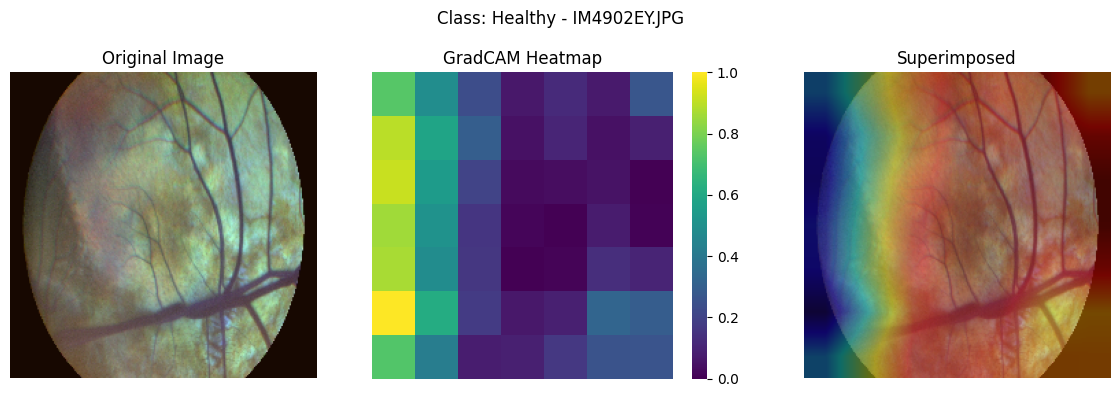

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


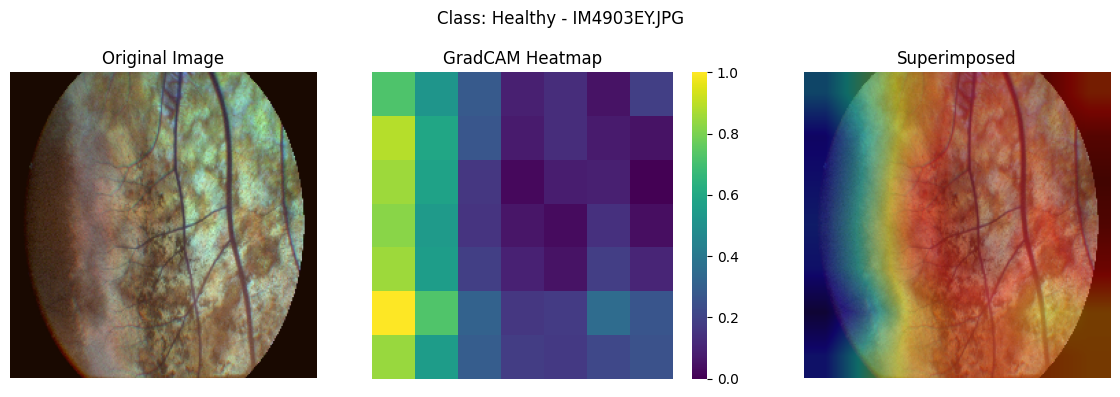

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


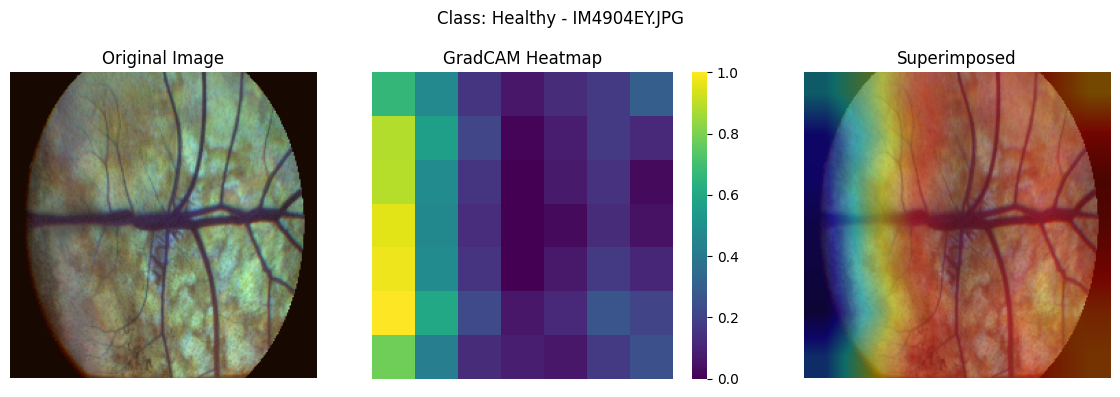

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


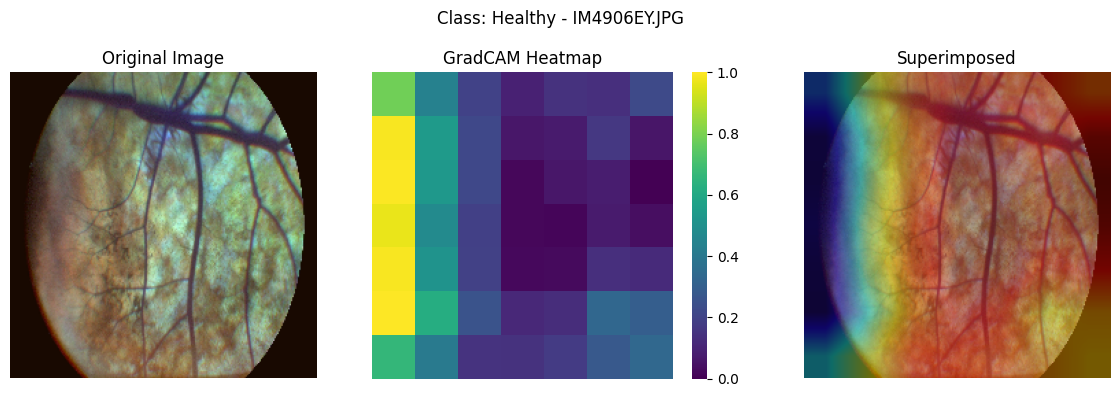

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


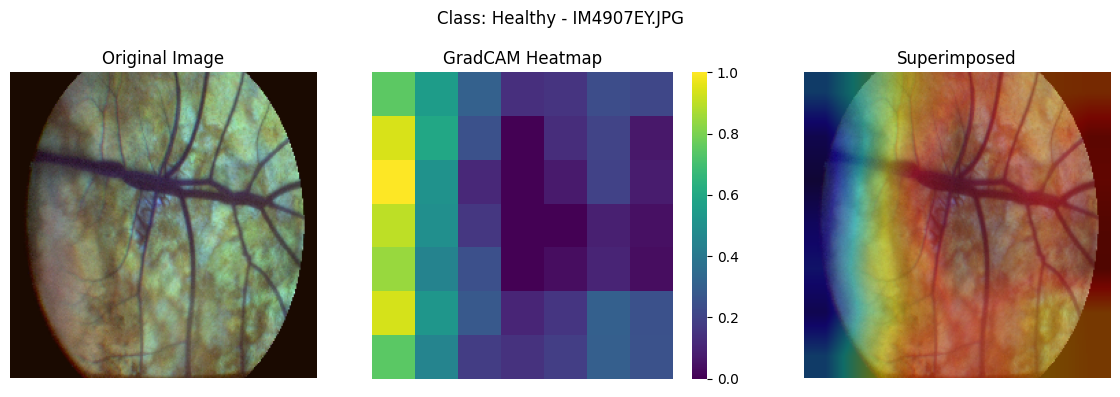

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


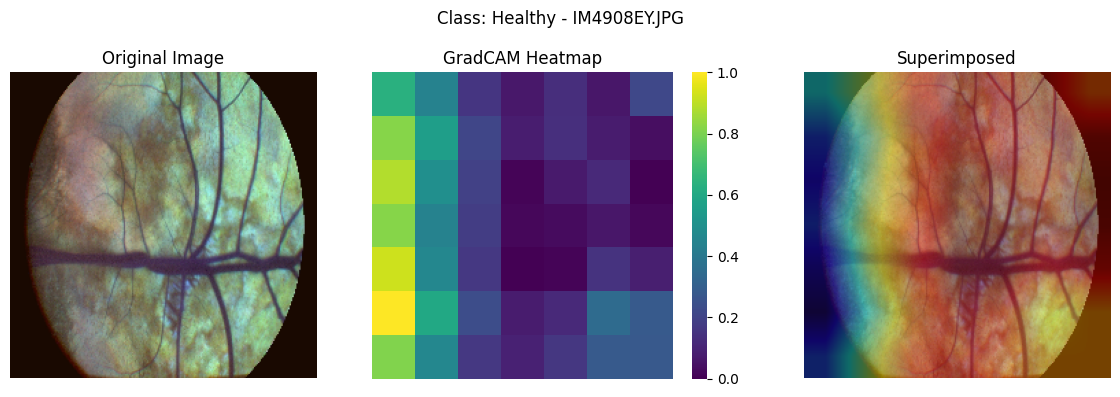

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


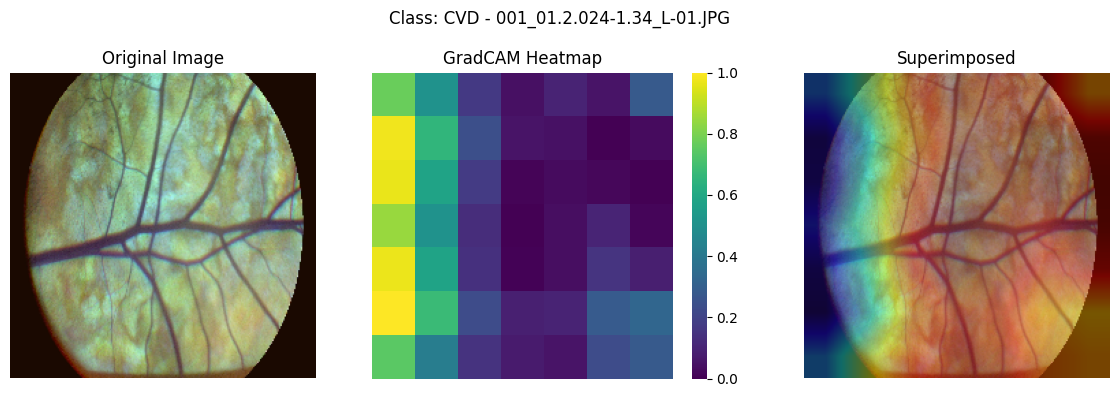

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


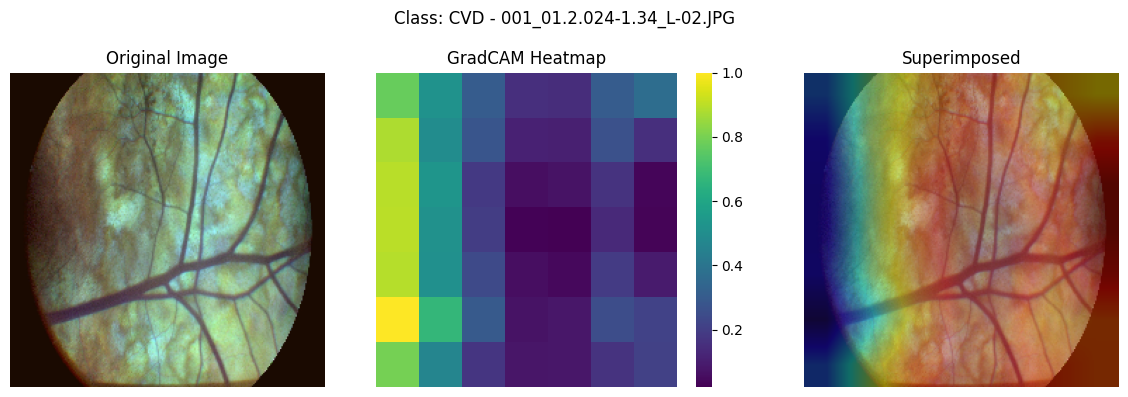

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


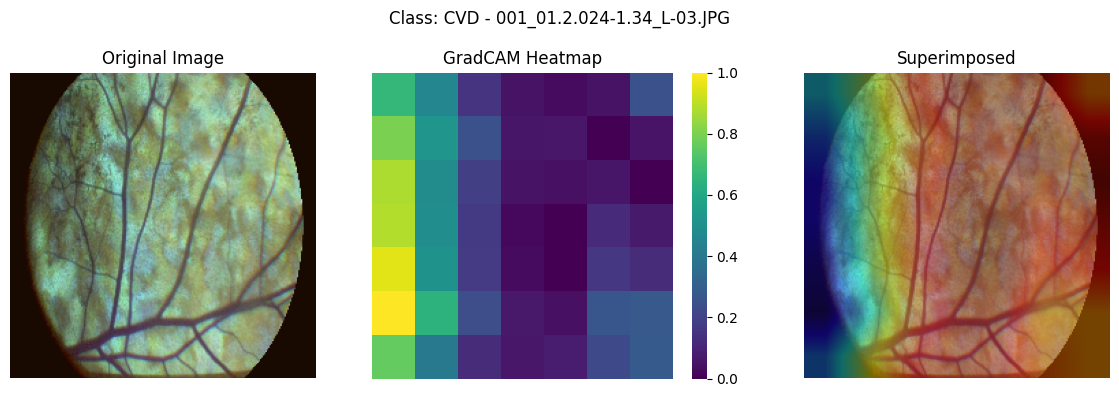

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


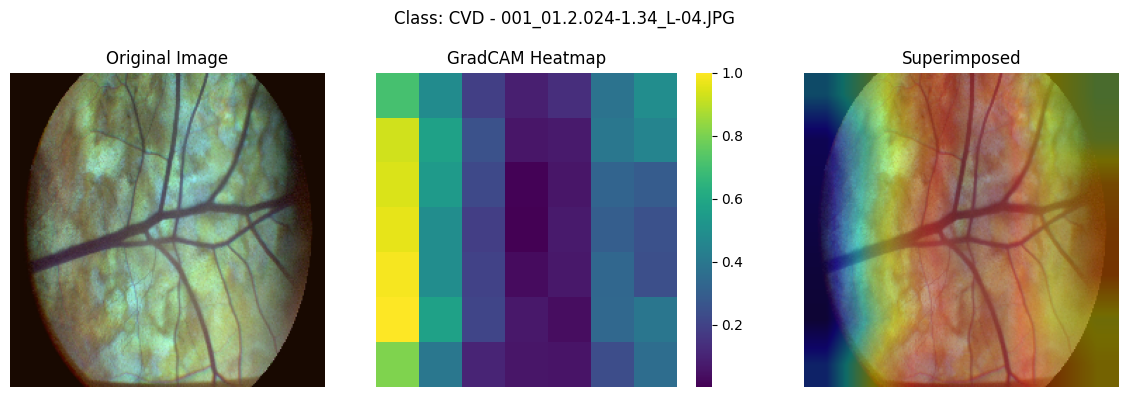

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


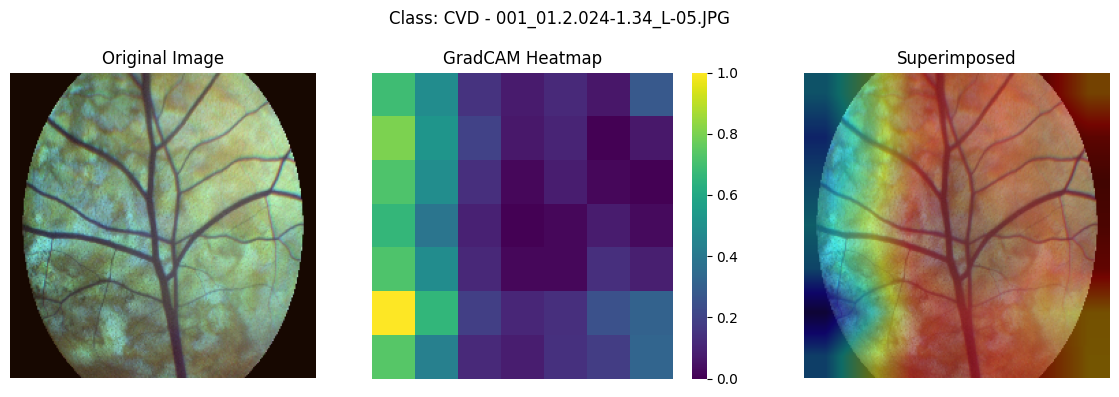

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


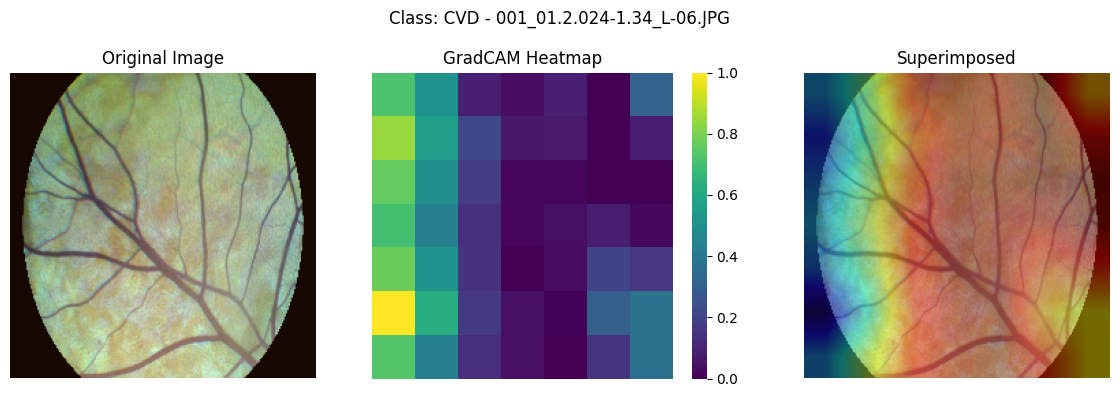

In [8]:
def plot_multiple_gradcam(model, base_path, num_images=6):
    resnet_model = model.get_layer('resnet50v2')
    last_conv_layer = "conv5_block3_3_conv"
    
    classes = ['0', '1']
    
    for class_name in classes:
        class_path = Path(base_path) / class_name
        image_files = list(class_path.glob('*.JPG'))[:num_images]
        
        for img_path in image_files:
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
            
            # Create Grad-CAM using ResNet base model
            grad_model = tf.keras.models.Model(
                [resnet_model.input],
                [resnet_model.get_layer(last_conv_layer).output, resnet_model.output]
            )
            
            with tf.GradientTape() as tape:
                conv_output, predictions = grad_model(img_array)
                class_channel = predictions[:, :, :, 0]
                
            grads = tape.gradient(class_channel, conv_output)
            pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
            
            conv_output = conv_output[0]
            heatmap = conv_output @ pooled_grads[..., tf.newaxis]
            heatmap = tf.squeeze(heatmap)
            heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
            heatmap = heatmap.numpy()
            
            plt.figure(figsize=(12, 4))
            plt.suptitle(f'Class: {"Healthy" if class_name=="0" else "CVD"} - {img_path.name}')
            
            plt.subplot(131)
            plt.imshow(tf.keras.preprocessing.image.array_to_img(img_array[0]))
            plt.title('Original Image')
            plt.axis('off')
            
            plt.subplot(132)
            sns.heatmap(heatmap, cmap='viridis')
            plt.title('GradCAM Heatmap')
            plt.axis('off')
            
            heatmap_resized = cv2.resize(heatmap, (224, 224))
            heatmap_uint8 = np.uint8(255 * heatmap_resized)
            heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
            
            original_img = tf.keras.preprocessing.image.array_to_img(img_array[0])
            original_array = np.array(original_img)
            superimposed = cv2.addWeighted(original_array, 0.6, heatmap_colored, 0.4, 0)
            
            plt.subplot(133)
            plt.imshow(superimposed)
            plt.title('Superimposed')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()

base_path = Path('../artifacts/dataset/retina_healthy_unhealthy/')
plot_multiple_gradcam(model, base_path)